# Первая модель 9 декабря 2025

## 1. Импорт библиотек и загрузка данных
Раздел «Imports & Data Loading»:  
Импорты  
Загрузка train 
Быстрый .head()  
Проверка формы датасета  
Краткие описания колонок (комментариями)

### Импорты

In [1]:
import os

import pandas as  pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


### Загрузка train и Быстрый .head()

In [2]:
data_path = '../../Data/Kaggle/titanic/'

files = os.listdir(data_path)
for i in range(len(files)):
    print(f'file {i} - {files[i]}')

file 0 - test.csv
file 1 - train.csv
file 2 - gender_submission.csv


In [3]:
df_train_row = pd.read_csv(f'{data_path}{files[1]}')
df_train_row.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Краткие описания колонок (комментариями)

PassengerId — уникальный идентификатор пассажира, просто индекс.  
Survived — целевая переменная: 0 = погиб, 1 = выжил.  
Pclass — класс обслуживания: 1-й (дорогой), 2-й, 3-й (дешёвый).  
Name — имя (можно извлечь звание/титул: Mr, Miss, Mrs, etc.).  
Sex — пол (ключевой фактор выживания).  
Age — возраст (много пропусков → важна обработка).  
SibSp — количество родственников по боковой линии (братья, сёстры, супруги).  
Parch — количество родителей и детей.  
Ticket — номер билета (можно делать группировки).  
Fare — стоимость билета (важно для богатых → выше шанс выжить).  
Cabin — каюта (почти всё пропущено, но буква палубы полезна).  
Embarked — порт отправления: S, C, Q.  
  
  
Так какбудет использоваться логистическая регресссия, то порядковая переменная будет обрабатываться как номинальная
До заполнения пропусков нужно обработать выбросы

## 2. Анализ данных и обработка признаков

Общие статитики по датасету  
Анализ численных признаков  
Обработка числовых признаков  
Анализ нечисловых признаков  
Обработка нечисловых признаков  
Создание новых признкаов

### Общие статитики по датасету

In [4]:
#Проверка на пропуски

df_train_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_train_row.isna().sum()/df_train_row.shape[0]*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Cabin нужно удалить так как пропусков больше

In [6]:
# Статистики

display(df_train_row.describe())
display(df_train_row.describe(include=['object']))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,G6,S
freq,1,577,7,4,644


In [7]:
#Создание DataFrame для препроцессинга
df_processed = df_train_row.copy()

### Распределение переменных по типу 

In [67]:
feature_id = 'PassengerId'
target_name = 'Survived'
list_num_ftrs = [	
     'Age'
    ,'SibSp'
    ,'Parch'
    ,'Fare'
]

list_num_with_outliers = [
     'Age'
    ,'Fare'
]

list_not_num_ftrs = [
     'Pclass'
    ,'Name'
    ,'Sex'
    ,'Ticket'
    ,'Cabin'
    ,'Embarked'

]

list_not_num_ftrs_empty = [
     'Cabin'
]
rare_num_col = [
     'SibSp'
    ,'Parch'
]

if set(df_train_row.columns) == set(list_num_ftrs + list_not_num_ftrs + [feature_id, target_name]):
    print('Все переменные распределены')
else:
    print('Переменные не распределены')

Все переменные распределены


In [9]:
display(df_train_row[list_num_ftrs].info())
display(df_train_row[list_not_num_ftrs].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     714 non-null    float64
 1   SibSp   891 non-null    int64  
 2   Parch   891 non-null    int64  
 3   Fare    891 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 28.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    891 non-null    int64 
 1   Name      891 non-null    object
 2   Sex       891 non-null    object
 3   Ticket    891 non-null    object
 4   Cabin     204 non-null    object
 5   Embarked  889 non-null    object
dtypes: int64(1), object(5)
memory usage: 41.9+ KB


None

### 2.1. Анализ численных признаков

Идея заполняем выбросы нижней и верхней границей межквартильного размаха

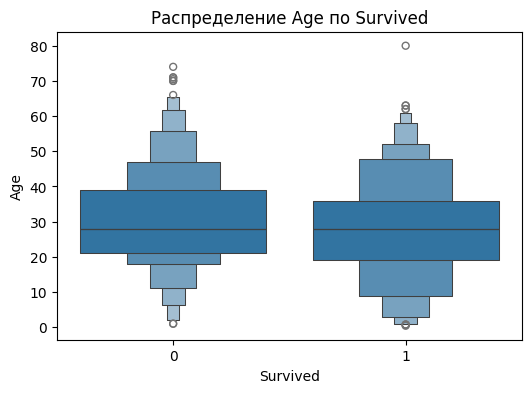

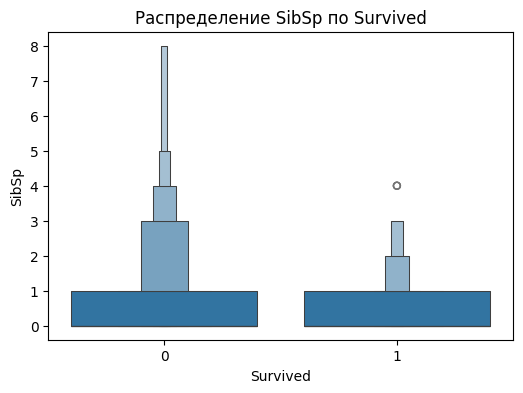

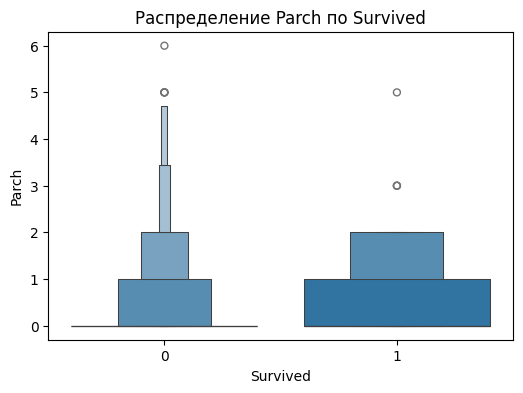

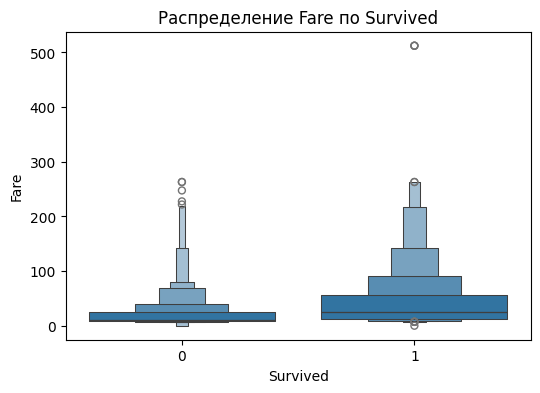

In [10]:
#Аналз распределений

for col in list_num_ftrs:
    plt.figure(figsize=(6, 4), dpi = 100)
    sns.boxenplot(data=df_train_row, x=target_name, y=col)
    plt.title(f"Распределение {col} по {target_name}")
    plt.show()

### 2.2 Заполняем пропуски

In [11]:
#Пайплайны для разынх типов

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

categorical_pipe_exceptions = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value='empty')),
])  
imputer = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, list_num_ftrs),
        ("cat", categorical_pipe, list(
            set(list_not_num_ftrs)-set(list_not_num_ftrs_empty)
        )),
        ("cat_exp", categorical_pipe_exceptions, list_not_num_ftrs_empty),
    ],
    remainder="passthrough"
)

imputer.set_output(transform="pandas")

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [12]:
display(df_train_row.isna().sum()/df_train_row.shape[0]*100)
       
imputer.fit(df_train_row)
df_processed = pd.DataFrame(imputer.transform(df_train_row) )

df_processed.columns = [
    col.split('__', 1)[1] if "__" in col else col
    for col in df_processed.columns
]

display(df_processed.isna().sum()/df_train_row.shape[0]*100)

df_processed[list_not_num_ftrs_empty[0]].value_counts()

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Age            0.0
SibSp          0.0
Parch          0.0
Fare           0.0
Ticket         0.0
Embarked       0.0
Name           0.0
Pclass         0.0
Sex            0.0
Cabin          0.0
PassengerId    0.0
Survived       0.0
dtype: float64

Cabin
empty          687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
              ... 
E17              1
A24              1
C50              1
B42              1
C148             1
Name: count, Length: 148, dtype: int64

In [13]:
#Создам отдельный класс, для обработки выбросов в числовых переменных с использованием межквартильного размаха

class ClipOutliersIQR(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=1.5):
        self.columns = columns
        self.k = k
        self.bounds_ = {} #Здесь будут сохранятся границы для конкретного столбца

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in self.columns:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            IQR = q3 - q1
            upper = q3 + self.k * IQR
            lower = q1 - self.k * IQR
            self.bounds_[col] = (lower, upper)

        return self

    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lower, upper) in self.bounds_.items():
            X[col] = X[col].clip(lower, upper)

        return X

In [14]:
clip_outlier_num = ClipOutliersIQR(columns=list_num_with_outliers)

df_processed = clip_outlier_num.fit_transform(df_train_row)

df_processed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,65.6344,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


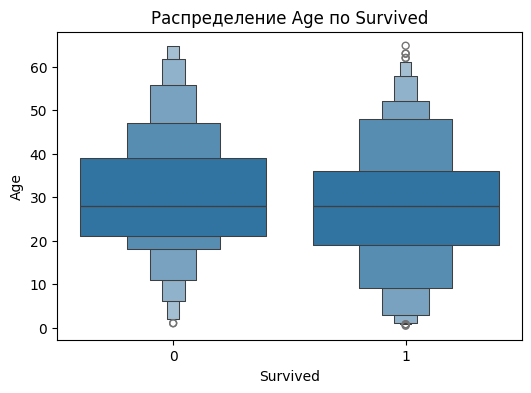

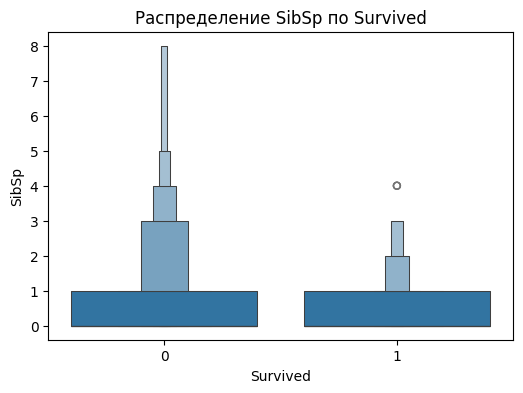

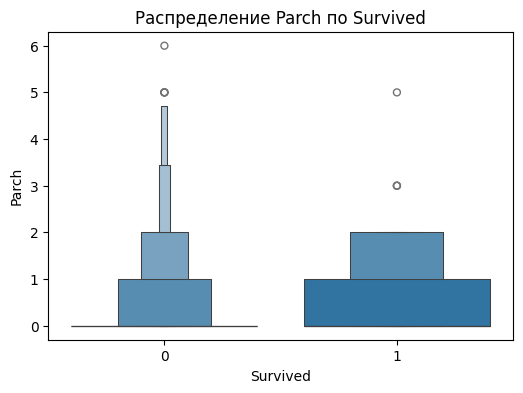

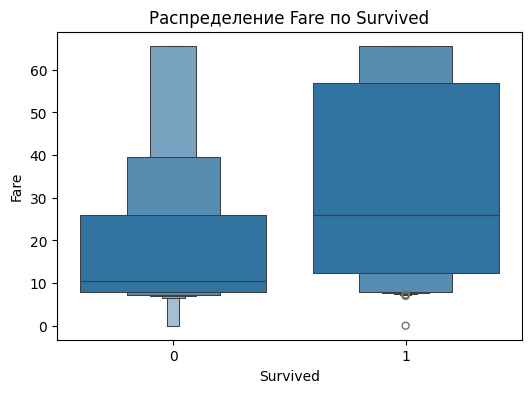

In [15]:
# Распределеиня после выбросов:
#Аналз распределений

for col in list_num_ftrs:
    plt.figure(figsize=(6, 4), dpi = 100)
    sns.boxenplot(data=df_processed, x=target_name, y=col)
    plt.title(f"Распределение {col} по {target_name}")
    plt.show()

In [16]:
df_processed['Parch'].value_counts(normalize=True)*100

Parch
0    76.094276
1    13.243547
2     8.978676
5     0.561167
3     0.561167
4     0.448934
6     0.112233
Name: proportion, dtype: float64

In [63]:
print(type(df_train_row['SibSp'].value_counts(normalize=True)))
rare_index = df_train_row['SibSp'].value_counts(normalize=True)*100<1
set(df_train_row['SibSp'].value_counts()[rare_index].index)

<class 'pandas.core.series.Series'>


{5, 8}

Для Parch и SibSp создадим категорию другие, куда попадут классы с менее 1 процентом.

In [69]:
class RareCategoriesGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, columns, min_freq=0.01, label_rare_categoty="other"):
        self.columns = columns
        self.min_freq = min_freq
        self.label_rare_categoty = label_rare_categoty
        self.rare_categories_ = {} #{column :set(rare_categories)}

        
    def fit(self, X, y=None):
        self.X = pd.DataFrame(X).copy()
        for col in self.columns:
            rare_index = X[col].value_counts(normalize=True)*100<1
            set(X[col].value_counts()[rare_index].index)
            self.rare_categories_[col] = set(X[col].value_counts()[rare_index].index)
            
        return self

    
    def transform(self, X):
        self.X = pd.DataFrame(X).copy()
        for col, rare_values in self.rare_categories_.items():
            X[col] = X[col].where(~X[col].isin(rare_values), self.label_rare_categoty)
            X[col] = X[col].apply(str)
        return X

In [70]:
rarecategoriesgrouper = RareCategoriesGrouper(columns=rare_num_col)

df_processed = rarecategoriesgrouper.fit_transform(df_processed)

df_processed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,65.6344,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [71]:
df_processed['Parch'].value_counts(normalize=True)*100

Parch
0        76.094276
1        13.243547
2         8.978676
other     1.683502
Name: proportion, dtype: float64